In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import os
from torch.optim import *

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"
import shutil

In [2]:
path = Path("/media/subhaditya/DATA/COSMO/Datasets/intel-image-classification")

In [3]:
torch.cuda.is_available()

True

In [9]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_folder(train = 'train',valid= 'test')
        .label_from_folder()
        .transform(get_transforms(), size=128)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

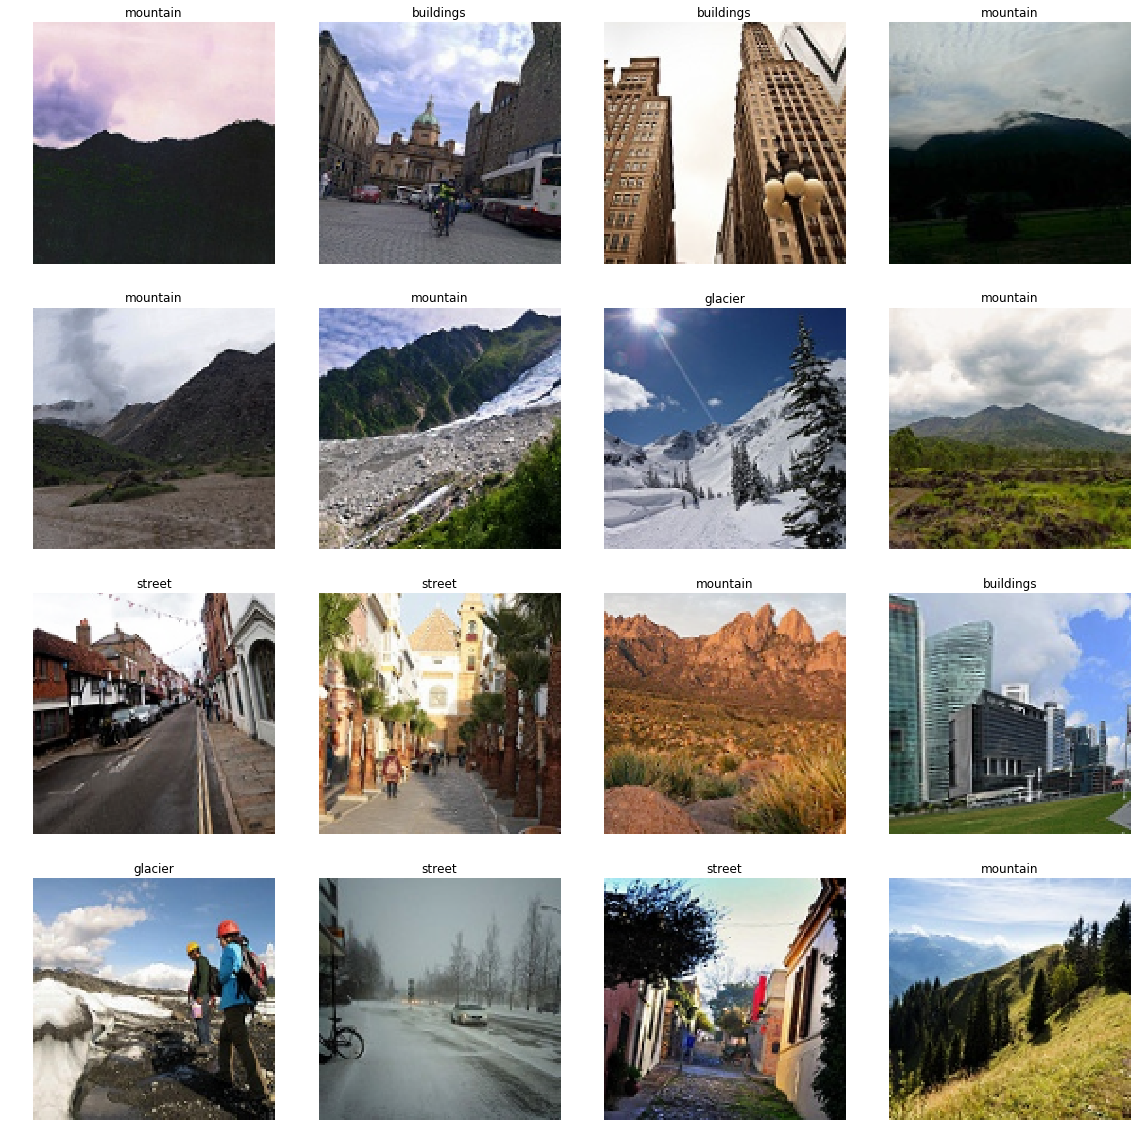

In [10]:
data.show_batch(4)

In [11]:
data.c

6

(array([2191.,    0., 2271.,    0., 2404.,    0., 2512.,    0., 2274., 2382.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

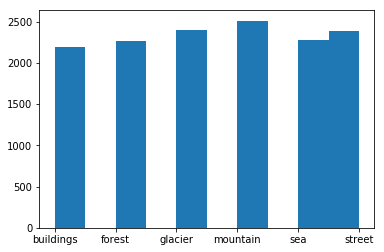

In [12]:
class_sam = [str(x) for x in data.train_ds.y]
plt.hist(class_sam)

In [13]:
from fastai.callbacks import OverSamplingCallback

In [14]:
learn = None
gc.collect()

32016

# EfficientNet

In [16]:
from efficientnet_pytorch import EfficientNet

arch = EfficientNet.from_pretrained("efficientnet-b0", advprop=True)
arch._fc = nn.Linear(1280, data.c)
loss_func = LabelSmoothingCrossEntropy()

Loaded pretrained weights for efficientnet-b0


In [17]:
learn = Learner(
    data,
    arch,
#     loss_func=loss_func,
    metrics=[accuracy,error_rate],
    opt_func=AdamW,
    callback_fns=[ShowGraph],
).mixup().to_fp16()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


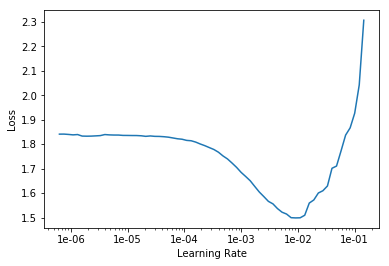

In [18]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.827275,4.463183,0.274333,0.725667,00:35
1,0.888035,nan,0.150000,0.850000,00:33
2,0.859101,1.014298,0.689000,0.311000,00:32
3,0.775381,0.477956,0.837000,0.163000,00:32
4,0.733539,0.650369,0.783000,0.217000,00:33
5,0.714395,0.395070,0.859000,0.141000,00:33
6,0.673055,0.290713,0.904333,0.095667,00:34
7,0.643034,0.290447,0.903000,0.097000,00:34
8,0.597980,0.244184,0.928667,0.071333,00:34
9,0.588928,0.227392,0.930000,0.070000,00:34


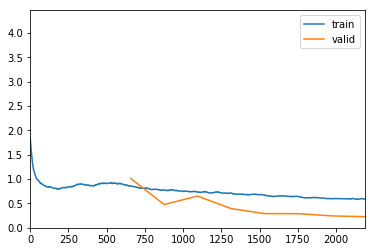

In [19]:
learn.unfreeze()
learn.fit_one_cycle(10,1e-2 ,wd=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.738957,nan,0.115000,0.885000,00:33
1,0.819314,2.159145,0.553000,0.447000,00:33
2,0.739926,0.338333,0.890333,0.109667,00:33
3,0.660960,0.319707,0.893333,0.106667,00:34
4,0.640313,0.241619,0.924333,0.075667,00:34


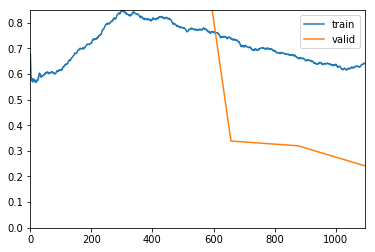

In [20]:
learn.unfreeze()
learn.fit_one_cycle(5,1e-2 ,wd=1e-3)

In [21]:
learn.save('st-1')

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


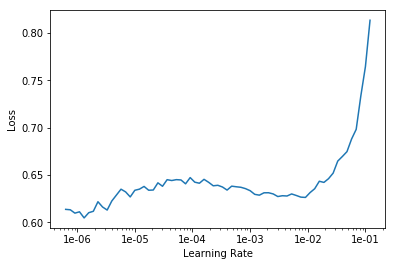

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.633667,0.238344,0.923333,0.076667,00:32
1,0.632406,0.236192,0.924333,0.075667,00:33
2,0.594082,0.236622,0.925333,0.074667,00:33
3,0.613194,0.234677,0.927333,0.072667,00:33
4,0.613159,0.234655,0.927000,0.073000,00:33


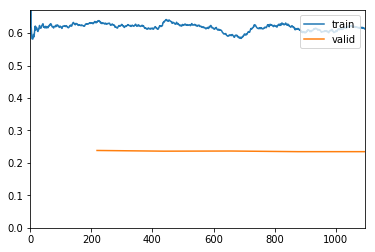

In [24]:
learn.unfreeze()
learn.fit_one_cycle(5,slice(1e-4) ,wd=1e-3)

# Efficient + label smoothing CE

In [46]:
learn = None
gc.collect()

25804

In [34]:
arch = EfficientNet.from_pretrained("efficientnet-b1", advprop=True)
arch._fc = nn.Linear(1280, data.c)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b1-0f3ce85a.pth" to /media/subhaditya/DATA/COSMO/Datasets-Useful/checkpoints/adv-efficientnet-b1-0f3ce85a.pth
100%|██████████| 30.1M/30.1M [02:03<00:00, 256kB/s] 

Loaded pretrained weights for efficientnet-b1


In [48]:
learn = cnn_learner(
    data,
    models.resnet34,
#     loss_func=loss_func,
    metrics=[accuracy,error_rate],
    opt_func=AdamW,
    callback_fns=[ShowGraph,OverSamplingCallback],
).mixup().to_fp16()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


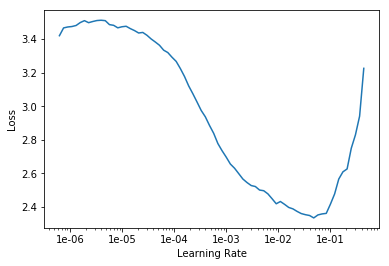

In [49]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.261732,11.126045,0.550667,0.449333,00:21
1,1.375528,4.742162,0.699333,0.300667,00:21
2,1.471936,1.189484,0.541333,0.458667,00:21
3,1.331555,nan,0.562333,0.437667,00:21
4,1.128924,1.461084,0.743667,0.256333,00:20
5,1.077269,nan,0.737667,0.262333,00:21
6,0.941639,nan,0.833000,0.167000,00:20
7,0.869717,nan,0.838333,0.161667,00:20
8,0.834604,nan,0.854667,0.145333,00:21
9,0.833678,nan,0.854667,0.145333,00:21


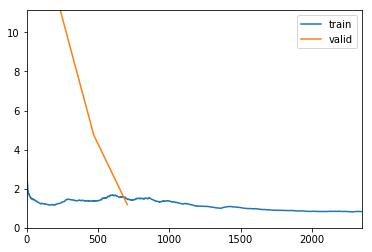

In [50]:
learn.unfreeze()
learn.fit_one_cycle(10,1e-2 ,wd=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.036777,0.766740,0.770333,0.229667,00:19
1,1.017807,nan,0.733333,0.266667,00:21
2,0.925654,0.660391,0.773333,0.226667,00:19
3,0.885006,nan,0.851000,0.149000,00:20
4,0.847593,nan,0.866000,0.134000,00:20


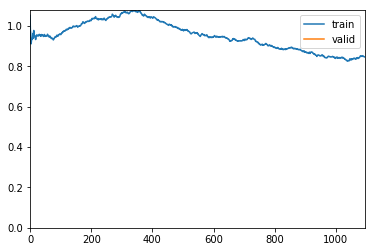

In [45]:
learn.unfreeze()
learn.fit_one_cycle(5,1e-2 ,wd=1e-3)

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()
